In [98]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import math

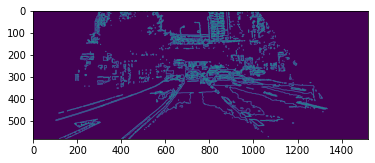

In [151]:
# 이미지
img = "./cap_img2/frame10.png"
A = cv2.imread(img, cv2.IMREAD_COLOR)

#roi
A_roi = A.copy()

X=200; Y=500; W=1520; H=580;
A_roi = A_roi[Y:Y+H, X:X+W]

mask1 = np.zeros(A_roi.shape[:3],dtype = np.uint8)
polygon = np.array([[300,0],[1020,0],[1450,580],[70,580]])
white = (255,255,255)
mask1 = cv2.fillConvexPoly(mask1,polygon,white)

a_copy = A_roi.copy()
a_result = cv2.bitwise_and(a_copy, mask1)

## 흰색 부분 추출
a = a_result.copy()
# hsv 영역 전환
a2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)

# 하얀색 hsv 색 범위 지정
low = (0, 0, 140)
up = (250, 90, 200)

a2_mask = cv2.inRange(a2, low, up)
a2_result = cv2.bitwise_and(a,a, mask = a2_mask)

## 노란색 부분 추출
y = a_result.copy()
# hsv 영역 전환
y2 = cv2.cvtColor(y,cv2.COLOR_BGR2HSV)

# 노란색 hsv 색 범위 지정2
low = (0, 20, 100)
up = (35, 30, 255)

y2_mask = cv2.inRange(y2, low, up)
y2_result = cv2.bitwise_and(y,y, mask = y2_mask)

# 캐니 추출
y2_canny = cv2.Canny(y2_result, 50 , 250)
a2_canny = cv2.Canny(a2_result, 50 , 250)

plt.imshow(a2_canny)

In [152]:
"""
# 노랑색 기준 허프변환P
yline = []
src = y2_result
dst = y2_canny
cdst = cv2.cvtColor(y2_canny, cv2.COLOR_GRAY2BGR)

cdstPy = np.copy(cdst)

linesP = cv2.HoughLinesP(dst, 1, np.pi/180, 60, None, 5, 20)
                         
#if linesP != None: 리스트에 데이터 없으면 오류나서 추가해야함 근데 데이터 있으면 오류남
for a in linesP:
    for by in a: # [] 가 두개 겹쳐있음
        if (by[2]-by[0]) != 0: # 분모가 0이면 나눌 수 없어
            radian = math.atan((by[3]-by[1])/(by[2]-by[0]))
            degree = radian * 180 / math.pi
            if degree >= 30 and degree <= 80 or degree >= -80 and degree <= -30: # 오른쪽
                yline.append(by)
                cv2.line(cdstPy, (by[0], by[1]), (by[2], by[3]), (0, 0, 255), 2, cv2.LINE_AA)
                
plt.imshow(cdstPy)
"""

'\n# 노랑색 기준 허프변환P\nyline = []\nsrc = y2_result\ndst = y2_canny\ncdst = cv2.cvtColor(y2_canny, cv2.COLOR_GRAY2BGR)\n\ncdstPy = np.copy(cdst)\n\nlinesP = cv2.HoughLinesP(dst, 1, np.pi/180, 60, None, 5, 20)\n                         \n#if linesP != None: 리스트에 데이터 없으면 오류나서 추가해야함 근데 데이터 있으면 오류남\nfor a in linesP:\n    for by in a: # [] 가 두개 겹쳐있음\n        if (by[2]-by[0]) != 0: # 분모가 0이면 나눌 수 없어\n            radian = math.atan((by[3]-by[1])/(by[2]-by[0]))\n            degree = radian * 180 / math.pi\n            if degree >= 30 and degree <= 80 or degree >= -80 and degree <= -30: # 오른쪽\n                yline.append(by)\n                cv2.line(cdstPy, (by[0], by[1]), (by[2], by[3]), (0, 0, 255), 2, cv2.LINE_AA)\n                \nplt.imshow(cdstPy)\n'

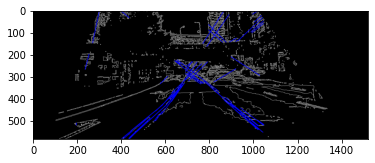

In [155]:
# 허프변환P
r = []
l = []
src = a2_result
dst = a2_canny
cdst = cv2.cvtColor(a2_canny, cv2.COLOR_GRAY2BGR)

cdstP = np.copy(cdst)

linesP = cv2.HoughLinesP(dst, 1, np.pi/180, 60, None, 5, 20)
                         
#if linesP != None: 리스트에 데이터 없으면 오류나서 추가해야함 근데 데이터 있으면 오류남
for a in linesP:
    for b in a: # [] 가 두개 겹쳐있음
        if (b[2]-b[0]) != 0: # 분모가 0이면 나눌 수 없어
            radian = math.atan((b[3]-b[1])/(b[2]-b[0]))
            degree = radian * 180 / math.pi
            if degree >= 30 and degree <= 80: # 오른쪽
                r.append(b)
                cv2.line(cdstP, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2, cv2.LINE_AA)
            elif degree >= -80 and degree <= -30: # 왼쪽
                l.append(b)
                cv2.line(cdstP, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2, cv2.LINE_AA)
                
plt.imshow(cdstP)

In [174]:
# r과 l에서 길이 조건으로 리스트에 저장
new_r = []
new_l = []

for i in range(len(r)):
    if math.dist([r[i][0], r[i][1]], [r[i][2], r[i][3]]) > 200:
        new_r.append(r[i])
        
for i in range(len(l)):
    if math.dist([l[i][0], l[i][1]], [l[i][2], l[i][3]]) > 200:
        new_l.append(l[i])

In [175]:
new_r 

[array([ 855,  389, 1023,  520], dtype=int32),
 array([654, 221, 842, 363], dtype=int32),
 array([ 867,  404, 1020,  537], dtype=int32)]

In [176]:
new_l

[array([433, 579, 608, 422], dtype=int32),
 array([450, 565, 605, 425], dtype=int32),
 array([615, 414, 744, 231], dtype=int32)]

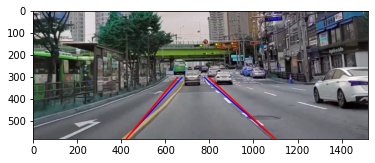

In [177]:
# roi이미지에서 선 그리기
a_copy = A_roi.copy()

# r 에서 x0 최소값이 있는 인덱스 i 찾기
least = []
for x in new_r:
    least.append(x[0])


least2 = []
for x in new_l:
    least2.append(x[2])
    
if not least and not least2:
    a_copy2 = a_copy.copy()
    cv2.line(a_copy2, (450, 100),(400, 580), (255, 0, 0), 4, cv2.LINE_AA)
    cv2.line(a_copy2, (900, 100),(1200, 580), (255, 0, 0), 4, cv2.LINE_AA)
    
elif not least or not least2:
    if not least:
        least_b = min(least2)
        i3 = least2.index(least_b)
        most_b = max(least2)
        i4 = least2.index(most_b)
        least_a = least_b
        least.append(least_a)
        i = least2.index(least_a)
        most_a = most_b
        least.append(most_a)
        i2 = least2.index(most_a)
        a_copy2 = a_copy.copy()
        

        ## l1
        m3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])
        n3 = l[i3][1] - (m3 * l[i3][0])

        ## l2
        m4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])
        n4 = l[i4][1] - (m4 * l[i4][0])
        
        ## r1
        m = -m3
        n = l[i][1] - (m * (550-(l[i][0]-550)))

        ## r2
        m2 = -m4
        n2 = l[i2][1] - (m2 * (550-(l[i2][0]-500)))
        
        cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+50, 300),(int((580-n)/m), 580), (0, 0, 255), 4, cv2.LINE_AA)
        cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-50, 300),(int((580-n4)/m4), 580), (0, 0, 255), 4, cv2.LINE_AA)
        cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+70, 300),(int((580-n)/m), 580), (255, 0, 0), 5, cv2.LINE_AA)
        cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-70, 300),(int((580-n4)/m4), 580), (255, 0, 0), 5, cv2.LINE_AA)
        
    elif not least2:
        least_a = min(least)
        i = least.index(least_a)
        most_a = max(least)
        i2 = least.index(most_a)
        least_b = least_a
        i3 = least.index(least_b)
        most_b = most_a
        i4 = least.index(most_b)    
        a_copy2 = a_copy.copy()
    
        ## r
        m = (r[i][3]-r[i][1])/(r[i][2]-r[i][0])
        n = r[i][1] - (m * r[i][0])

        ## r2
        m2 = (r[i2][3]-r[i2][1])/(r[i2][2]-r[i2][0])
        n2 = r[i2][1] - (m2 * r[i2][0])

        ## l1
        m3 = -m
        n3 = r[i][1] - (m3 * (550-(r[i][0]-550)))

        ## l2
        m4 = -m2
        n4 = r[i2][1] - (m4 * (550-(r[i2][0]-550)))

    
        cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+50, 300),(int((580-n)/m), 580), (0, 0, 255), 4, cv2.LINE_AA)
        cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-50, 300),(int((580-n4)/m4), 580), (0, 0, 255), 4, cv2.LINE_AA)
        cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+70, 300),(int((580-n)/m), 580), (255, 0, 0), 5, cv2.LINE_AA)
        cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-70, 300),(int((580-n4)/m4), 580), (255, 0, 0), 5, cv2.LINE_AA)
    
    
    
else:
    least_a = min(least)
    i = least.index(least_a)
    most_a = max(least)
    i2 = least.index(most_a)
    least_b = min(least2)
    i3 = least2.index(least_b)
    most_b = max(least2)
    i4 = least2.index(most_b)
    a_copy2 = a_copy.copy()
    
    ## r1
    m = (r[i][3]-r[i][1])/(r[i][2]-r[i][0])
    n = r[i][1] - (m * r[i][0])
    
    ## r2
    m2 = (r[i2][3]-r[i2][1])/(r[i2][2]-r[i2][0])
    n2 = r[i2][1] - (m2 * r[i2][0])

    ## l1
    m3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])
    n3 = l[i3][1] - (m3 * l[i3][0])

    ## l2
    m4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])
    n4 = l[i4][1] - (m4 * l[i4][0])
    
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+50, 300),(int((580-n)/m), 580), (0, 0, 255), 4, cv2.LINE_AA)
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-50, 300),(int((580-n4)/m4), 580), (0, 0, 255), 4, cv2.LINE_AA)
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)+70, 300),(int((580-n)/m), 580), (255, 0, 0), 5, cv2.LINE_AA)
    cv2.line(a_copy2, (int(((-n4/m4)+(-n/m))/2)-70, 300),(int((580-n4)/m4), 580), (255, 0, 0), 5, cv2.LINE_AA)
    
    
plt.imshow(a_copy2)

In [178]:
a_copy3 = A_roi.copy()

pts = np.array([[int(((-n4/m4)+(-n/m))/2)+50, 300], [int(((-n4/m4)+(-n/m))/2)-50, 300],
                [int((580-n4)/m4), 580],[int((580-n)/m), 580]], np.int32)
area = cv2.fillConvexPoly(a_copy3, pts, (0, 255, 0))
a_copy4 = cv2.addWeighted(a_copy3, 0.4, a_copy2, 0.6, 0)

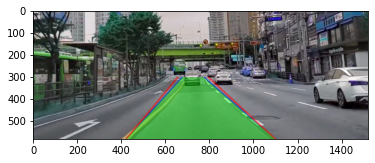

In [179]:
plt.imshow(a_copy4)